In [1]:
#A data based approach using Stack Overflow’s developer survey data from 2018.
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn import cluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 

### Business Understanding:
The Stack Overflow’s 2018 survey consisted of various questions related to Education, Employment, Technology trend etc. Survey was answered by developers ranging from Students to Professionals.

Let's analyse this data to see what effects different factors have on a Professional's Job Satisfaction. We will try to answer the following questions:
1. How respondents rank the Package Benefits offered by the Jobs?
2. What is the effect of the most important (ranked 1 above) benefit on Job Stisfaction?
3. Are the people who Program as a Hobby, more Satisfied with their Jobs?
4. Are the people who have acceptance towards Artificial Intelligence (AI), more Satisfied with their Jobs?

### Data Understanding:
Let's read both the 'survey_results_schema' and the 'survey_results_public' dataframes



In [2]:
#Read the survey_results_schema.csv -- Questions of the survey conducted by Stack Overflow in 2018
schema = pd.read_csv('D:\\DataScientist\\NanoDegree\\Proj1\\survey_results_schema.csv')
print('Dataset shape:',schema.shape)
print(schema.head())

Dataset shape: (129, 2)
       Column                                       QuestionText
0  Respondent  Randomized respondent ID number (not in order ...
1       Hobby                            Do you code as a hobby?
2  OpenSource         Do you contribute to open source projects?
3     Country          In which country do you currently reside?
4     Student  Are you currently enrolled in a formal, degree...


In [3]:
#Read the survey_results_public.csv -- answers to the survey conducted by Stack Overflow in 2018
df_full = pd.read_csv('D:\\DataScientist\\NanoDegree\\Proj1\\survey_results_public.csv')
print('Dataset shape:',df_full.shape)

print(df_full.columns.tolist())

D:\DataScientist\Anaconda\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataset shape: (98855, 129)
['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 'LastNewJob', 'AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10', 'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1', 'JobContactPriorities2', 'JobContactPriorities3', 'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4', 'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7', 'UpdateCV', 'Currency', 'Salary', 'SalaryType', 'ConvertedSalary', 'Curr

### Data Understanding - Remove unwanted features / columns

There are 129 questions in the survey and 98855 developers have responded.

Let's remove the unwanted columns that are not related to Job Satisfaction. These are the Columns related to StackOverflow Survey questions, HypotheticalTools related questions, Advertisement related questions. We can also remove Salary, SalaryType, Currency and CurrencySymbol as we are going to use ConvertedSalary column, so these are redundent.

Let's also remove the following categorical columns that have multiple choice answers (like Select all / check all) as they are very difficult to encode:
DevType, CommunicationTools, EducationTypes, SelfTaughtTypes, Gender, SexualOrientation, RaceEthnicity, LanguageWorkedWith, LanguageDesireNextYear, DatabaseWorkedWith, DatabaseDesireNextYear, PlatformWorkedWith, PlatformDesireNextYear, FrameworkWorkedWith, FrameworkDesireNextYear, IDE, OperatingSystem, NumberMonitors, Methodology, VersionControl, CheckInCode, Gender, SexualOrientation, RaceEthnicity.


In [4]:
#remove unwanted categorical columns
df_full = df_full.drop(df_full.filter(regex='StackOverflow|HypotheticalTools|Ad|Survey').columns,axis=1,errors='ignore')
df_full = df_full.drop(['Salary','SalaryType','Currency','CurrencySymbol'],axis=1,errors='ignore')
df_full = df_full.drop(['DevType', 'CommunicationTools', 'EducationTypes', 'SelfTaughtTypes', 
                        'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 
                        'PlatformWorkedWith', 'PlatformDesireNextYear', 'FrameworkWorkedWith', 'FrameworkDesireNextYear', 
                        'IDE', 'OperatingSystem', 'NumberMonitors', 'Methodology', 'VersionControl', 'CheckInCode', 
                        'Gender', 'SexualOrientation', 'RaceEthnicity'],axis=1,errors='ignore')
    
print('Shape of resulting dataset:',df_full.shape)

Shape of resulting dataset: (98855, 75)


### Data Processing - Encode all the required columns

In [5]:
#Function to remove the NaN values from the dataset by dropping the rows with NaNs
def remove_NaNs(df,col):
    '''
    INPUT
    df - pandas dataframe 
    col - list of the column/s to search for NaNs
    
    OUTPUT
    DataFrame with NA entries dropped from it.
    '''
    return df.dropna(subset=col,axis=0)

In [6]:
#Encode all the required columns

  
#Encode JobSatisfaction - make 3 wider buckets instead of 7 finer
df_full['JobSatisfactionCode'] = df_full.JobSatisfaction.apply(lambda x:{'Extremely satisfied':2,
                                                                         'Moderately satisfied':2,
                                                                         'Slightly satisfied':1,
                                                                         'Neither satisfied nor dissatisfied':1,
                                                                         'Slightly dissatisfied':1,
                                                                         'Moderately dissatisfied':0,
                                                                         'Extremely dissatisfied':0                      
                                                                        }.get(x,x))

#Encode CareerSatisfaction - make 3 wider buckets instead of 7 finer
df_full['CareerSatisfactionCode'] = df_full.CareerSatisfaction.apply(lambda x:{'Extremely satisfied':2,
                                                                         'Moderately satisfied':2,
                                                                         'Slightly satisfied':1,
                                                                         'Neither satisfied nor dissatisfied':1,
                                                                         'Slightly dissatisfied':1,
                                                                         'Moderately dissatisfied':0,
                                                                         'Extremely dissatisfied':0                      
                                                                        }.get(x,x))

#Encode Country column using LabelEncoder
lb_country = LabelEncoder()
df_full["Country"] = df_full["Country"].fillna('None')
df_full["CountryCode"] = lb_country.fit_transform(df_full["Country"])
#print(df_full[["Country", "CountryCode"]].head())


#Encode lb_HopeFiveYears column using LabelEncoder
lb_HopeFiveYears = LabelEncoder()
df_full["HopeFiveYears"] = df_full["HopeFiveYears"].fillna('None')
df_full["HopeFiveYearsCode"] = lb_country.fit_transform(df_full["HopeFiveYears"])


### Data Understanding - Assess missing values in columns

Let's perform an assessment of how much missing data is there in each column of the dataset

In [7]:
# find the count of NaNs.
missing_features = df_full.isnull().sum()

#Calculate the missing % (missing/total_rows)
missing_features = missing_features[missing_features > 0]/(df_full.shape[0]) * 100

#List out the columns with more than 50% missing values
missing_50 = missing_features[missing_features > 50]

print('Columns with more than 50% missing values')
print(missing_50)

Columns with more than 50% missing values
JobContactPriorities1    50.729857
JobContactPriorities2    50.729857
JobContactPriorities3    50.729857
JobContactPriorities4    50.729857
JobContactPriorities5    50.729857
JobEmailPriorities1      53.251732
JobEmailPriorities2      53.251732
JobEmailPriorities3      53.251732
JobEmailPriorities4      53.251732
JobEmailPriorities5      53.251732
JobEmailPriorities6      53.251732
JobEmailPriorities7      53.251732
ConvertedSalary          51.745486
TimeAfterBootcamp        93.270952
HackathonReasons         74.011431
ErgonomicDevices         65.547519
MilitaryUS               84.036215
dtype: float64


### Data Understanding - Assessing missing value columns and removing them from dataset

The above columns have more than 50% missing values. Let's analyse them:

JobContactPriorities and JobEmailPriorities related columns have questions regarding the preference of respondent in case a company wanted to contact them about a job opportunity. These columns are not related to our analysis regarding Job Satisfaction, so can be safely dropped.

ConvertedSalary - We need that for our analysis, so we need to take care of NaN values later

There remaining columns are not related to our survey so can be dropped safely.

Let's do this clean up activity now by dropping all these columns except ConvertedSalary.

In [8]:
#Remove ConvertedSalary from missing_50
missing_50.drop('ConvertedSalary',inplace=True,errors='ignore')

#Drop the columns in missing_50 from df_full 
df_full.drop(missing_50.index, axis=1,inplace=True,errors='ignore')

print('Shape of resulting dataset:',df_full.shape)
print('Columns remaining:',df_full.columns)

Shape of resulting dataset: (98855, 63)
Columns remaining: Index(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 'YearsCoding',
       'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction',
       'HopeFiveYears', 'JobSearchStatus', 'LastNewJob', 'AssessJob1',
       'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6',
       'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10',
       'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3',
       'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6',
       'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9',
       'AssessBenefits10', 'AssessBenefits11', 'UpdateCV', 'ConvertedSalary',
       'TimeFullyProductive', 'AgreeDisagree1', 'AgreeDisagree2',
       'AgreeDisagree3', 'AIDangerous', 'AIInteresting', 'AIResponsible',
       'AIFuture', 'EthicsChoice', 'EthicsReport', 'EthicsResponsible',
       'EthicalImplication

### Data Understanding - Assess missing values in rows

Let's perform an assessment of how much missing data is there in each row of the dataset

(98855, 63)
(69276, 63)


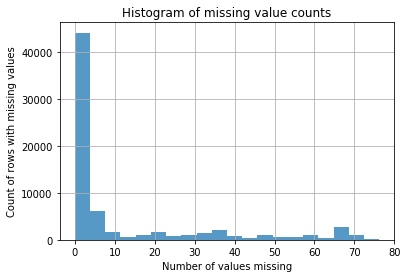

In [9]:
#Before we assess the missing values in the rows, let's first remove all the rows where JobSatisfaction is NaN
print(df_full.shape)
df_full = remove_NaNs(df_full,['JobSatisfaction'])
print(df_full.shape)

# find the count of NaNs.
missing_row_data = df_full.isnull().sum(axis=1)/(df_full.shape[1]) * 100

#Sort the values before plotting the hist
missing_row_data.sort_values(ascending=False,inplace=True)

#Plot distribution of missing value counts
plt.hist(missing_row_data, bins=20, alpha=0.75)

plt.xlabel('Number of values missing')
plt.ylabel('Count of rows with missing values')
plt.title('Histogram of missing value counts')
plt.grid(True)
plt.show()

In [10]:
missing_row_data[missing_row_data > 50]

#List out the rows with more than 50% missing values
missing_50 = missing_row_data[missing_row_data > 50]

print('Rows with more than 50% missing values')
print(missing_50.shape[0],missing_50.shape[0]/df_full.shape[0]*100,'%')


#df_full.drop(missing_50.index, axis=0,inplace=True,errors='ignore')
print('Shape of resulting dataset:',df_full.shape)


Rows with more than 50% missing values
6533 9.430394364570702 %
Shape of resulting dataset: (69276, 63)


### Data Understanding - Missing values in rows

There are 9.4% rows with more than 50% missing values. 
But we will keep all the rows for analysis as we want as much samples as possible. 
We will fill the NaNs whereever required.

In [11]:
def prepare_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Create X as all the columns that are not the Salary column
    2. Create y as the Salary column
    3. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    4. For each numeric variable in X, fill the column with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    print(df.shape)
    
    print('1. Create X with all the columns except JobSatisfactionCode')
    X = df.drop('JobSatisfactionCode',axis=1)
    print(X.shape)
    
    print('2. Create y as JobSatisfactionCode')
    y = df.JobSatisfactionCode
    
    print('3. Drop the Respondent column and other encoded columns from X')
    X = X.drop(['Respondent','Country','HopeFiveYears','JobSatisfaction','CareerSatisfaction'],axis=1)
    print(X.shape)

    print('4. For ConvertedSalary use mean. For other numeric variable in X, fill the column with the mode value of the column.')
    num_var_all = X.select_dtypes(include=['float','int']).columns

    # fill mode in the all the cols except ConvertedSalary. Fill mean in ConvertedSalary
    for var in num_var_all:
        if(var == 'ConvertedSalary'):
            X['ConvertedSalary'].fillna(X['ConvertedSalary'].mean(),inplace=True)
        else:
            X[var].fillna(X[var].mode()[0], inplace=True)

            
    print('5. Create dummy columns for all the categorical variables in X, drop the original columns')
    cat_var_all = X.select_dtypes(include=['object']).columns

    # hot-encode categorical columns, remove remaining unwanted categorical columns
    for var in cat_var_all:
        X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
             
    return X, y

In [12]:
#Use the function to create X and y
X, y = prepare_data(df_full) 
print(X.shape)

(69276, 63)
1. Create X with all the columns except JobSatisfactionCode
(69276, 62)
2. Create y as JobSatisfactionCode
3. Drop the Respondent column and other encoded columns from X
(69276, 57)
4. For ConvertedSalary use mean. For other numeric variable in X, fill the column with the mode value of the column.
5. Create dummy columns for all the categorical variables in X, drop the original columns
(69276, 166)


### Data Modeling:

Let's try to answer these 2 questions
1. How respondents rank the Package Benefits offered by the Jobs?
2. What is the effect of the most important (ranked 1 above) benefit on Job Stisfaction?


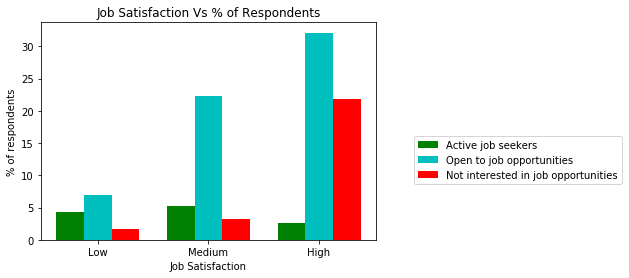

In [13]:
#First let's see the Effect of Job Satisfaction, 
#i.e. are the respondents happy with their current job or are they looking for a switch.

#Remove all the rows with NaNs in the columns
df = remove_NaNs(df_full,['JobSearchStatus','JobSatisfactionCode'])

#Select respondents who are not students and are employeed as this is related to Job Satisfaction
df = df[df['Student'] == 'No']
df = df[df['Employment'].str.contains('Not employed') == False]

df_plot = ((df[['JobSearchStatus','JobSatisfactionCode']]).groupby(['JobSearchStatus','JobSatisfactionCode']).size()/len(df)*100)

#Plot 3 line graphs, 1 for each JobSearchStatus
df_plot_1 = df_plot[df_plot.index.get_level_values(0) == 'I am actively looking for a job']
df_plot_2 = df_plot[df_plot.index.get_level_values(0) == "I’m not actively looking, but I am open to new opportunities"]
df_plot_3 = df_plot[df_plot.index.get_level_values(0) == 'I am not interested in new job opportunities']

ax = plt.subplot(111)

#Plot the JobSatisfactionCode Vs MeanSalary for each JobSearchStatus
ax.bar(df_plot_1.index.get_level_values(1)+0,df_plot_1,width=0.25,color='g',label='Active job seekers')
ax.bar(df_plot_2.index.get_level_values(1)+0.25,df_plot_2,width=0.25,color='c',label='Open to job opportunities')
ax.bar(df_plot_3.index.get_level_values(1)+0.5,df_plot_3,width=0.25,color='r',label='Not interested in job opportunities')

plt.xlabel('Job Satisfaction', fontsize=10)
plt.ylabel('% of respondents', fontsize=10)
plt.title('Job Satisfaction Vs % of Respondents')
ax.legend(bbox_to_anchor=(1.75, 0.5))
plt.xticks(np.arange(0,3,1)+0.25)
ax.set_xticklabels(['Low','Medium','High'])
#ax.yaxis.grid() # horizontal lines
plt.show()

#### Inferences from 'Job Satisfaction Vs Mean Salary' plot 
- People who are active job seekers have the least job satisfaction, followed by people who are open to opportunities
- People who are most satisfied with their jobs are not interested in new job opportunities

There is a set of 11 questions that I considered for further analysis. These are related to assessing a job's benefits package. Respondents ranked the following aspects of a job's benefits package from most to least important, where 1 is most important and 11 is least important.
1. Salary and/or bonuses
2. Stock options or shares
3. Health insurance
4. Parental leave
5. Fitness or wellness benefit 
6. Retirement or pension savings matching
7. Company-provided meals or snacks
8. Computer/office equipment allowance
9. Childcare benefit
10. Transportation benefit 
11. Conference or education budget

In [14]:
#Remove NaNs from AssessBenefits question set
df = remove_NaNs(df_full,['AssessBenefits1'])

#Create a new dataframe with columns to hold the percentage of importance of Benefits assessed by the resopondents
df_benefits = pd.DataFrame()

#To get the full Question Text from schema 
pd.set_option('display.max_colwidth', -1)

#For the 11 Questions, find the importance of Benefits rated by the respondents 
#Each Question will have rating from 1 to 11, 1 being most important
for benefit_id in range(1,12):
    #Create the Column name by appending Question # to 'AssessBenefits'
    col = 'AssessBenefits'+str(benefit_id)
    
    #Get the corresponding Benefit Name from the schema
    benefit = (schema[schema['Column'] == col]['QuestionText']).to_string()
    
    #Manipulations required to get the Benefit name
    benefit = (benefit[benefit.find('important.')+11:])
    if ('(' in benefit):
        benefit = (benefit[:benefit.find('(')])
    #print(benefit)
    
    #Find the number of respondents for each rating for the Benefit - say Salary and Bonuses
    '''e.g. AssessBenefits1
        1.0     45588
        2.0     7361 
        3.0     3758 
        4.0     2390 
        5.0     1638 
        6.0     1215 
        7.0     854  
        8.0     666  
        9.0     523  
        10.0    495  
        11.0    430
        '''
    count_per_rating = (df[col]).groupby(df[col]).count()
    #print(count_per_rating)

    #Find the importance of that benefit - that is the rating with maximum number of respondents, 1.0 in the above example
    imp = int((count_per_rating/len(df)).idxmax())

    # % of respondents selecting that importance 
    perc = count_per_rating.max()/len(df)*100
    
    #Add the above information in the df_benefits dataframe
    df_benefits = df_benefits.append({'cols': benefit+':'+str(imp),
                                      'benefit':benefit,
                                      'perc': perc,
                                      'imp': imp},ignore_index=True)
    

#Sort the dataframe 
df_benefits.sort_values(by=['imp','perc'],ascending=[True, False],inplace=True)

#Revert the display setting
pd.set_option('display.max_colwidth', 55)


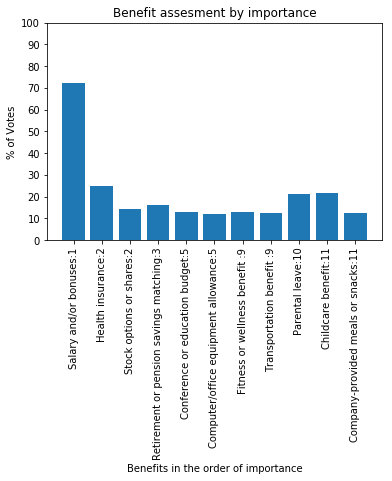

In [15]:
#Plot the bar chart for Benefits assessment by importance
index = np.arange(0,110,10)
plt.bar(df_benefits.cols,df_benefits.perc)
plt.xlabel('Benefits in the order of importance', fontsize=10)
plt.ylabel('% of Votes', fontsize=10)
plt.xticks(df_benefits.cols, fontsize=10, rotation=90)
plt.yticks(index,fontsize=10)
plt.title('Benefit assesment by importance')
plt.show()

#### Inference
This answers our 1st question - How respondents rank the Package Benefits offered by the Jobs?

The above chart indicates that 70% of repondents have selected 'Salary and/or Bouneses' as the most important benefit followed by 'Health Insurance' (~25%) and 'Stock options or shares' (~13%) as number 2. 

I will consider 'Salary and/or bonuses' benefit for further analysis. Let's see if there is any relationship between Salary, JobSatisfaction and JobSearchStatus.

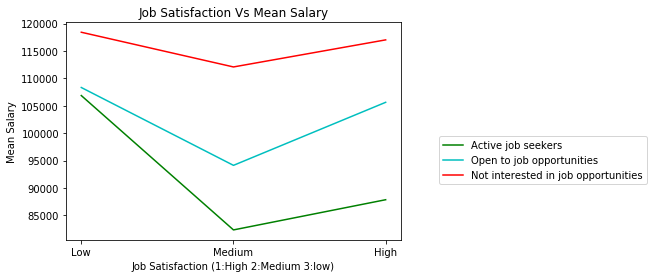

In [16]:
#Remove all the rows with NaNs in the 3 columns
df = remove_NaNs(df_full,['JobSearchStatus','ConvertedSalary','JobSatisfactionCode',])

#Select respondents who are not students and are employeed as this is related to Job Satisfaction
df = df[df['Student'] == 'No']
df = df[df['Employment'].str.contains('Not employed') == False]

df_plot = ((df[['JobSearchStatus','JobSatisfactionCode','ConvertedSalary']]).groupby(['JobSearchStatus','JobSatisfactionCode']).mean().sort_values(by=['JobSearchStatus','JobSatisfactionCode'],ascending=False))

#Plot 3 line graphs, 1 for each JobSearchStatus
df_plot_1 = df_plot[df_plot.index.get_level_values(0) == 'I am actively looking for a job']
df_plot_2 = df_plot[df_plot.index.get_level_values(0) == "I’m not actively looking, but I am open to new opportunities"]
df_plot_3 = df_plot[df_plot.index.get_level_values(0) == 'I am not interested in new job opportunities']
ax = plt.subplot(111)

#Plot the JobSatisfactionCode Vs MeanSalary for each JobSearchStatus
ax.plot(df_plot_1.index.get_level_values(1),df_plot_1.ConvertedSalary,'g',label='Active job seekers')
ax.plot(df_plot_2.index.get_level_values(1),df_plot_2.ConvertedSalary,'c',label='Open to job opportunities')
ax.plot(df_plot_3.index.get_level_values(1),df_plot_3.ConvertedSalary,'r',label='Not interested in job opportunities')
plt.xlabel('Job Satisfaction (1:High 2:Medium 3:low)', fontsize=10)
plt.ylabel('Mean Salary', fontsize=10)
#plt.xticks((np.arange(1,4)))
plt.xticks(np.arange(0,3,1))
ax.set_xticklabels(['Low','Medium','High'])

plt.title('Job Satisfaction Vs Mean Salary')
ax.legend(bbox_to_anchor=(1.75, 0.5))
#ax.grid()
plt.show()

#### Inferences from 'Job Satisfaction Vs Mean Salary' plot 
This answers our 2nd question - What is the effect of the most important (ranked 1 above) benefit on Job Stisfaction?

- People who are 'Active job seekers' have below average salaries. These are the people who are looking for a better paying jobs.
- Overall the job satisfaction is seen to go down (High to Medium) as the mean salary goes down upto a certain extent. After that even higher mean salary is not the factor in boosting the job satisfaction in all 3 groups.


### Data Modeling:

Let's try to answer next 2 questions
3. Are the people who Program as a Hobby, more Satisfied with their Jobs?
4. Are the people who have acceptance towards Artificial Intelligence (AI), more Satisfied with their Jobs?


D:\DataScientist\Anaconda\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


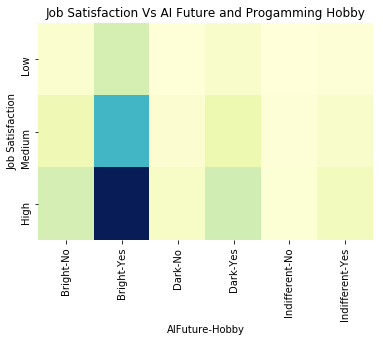

In [17]:
#Let's see if there is any relation between Coding being an Hobby/profession to Job Satisfaction
#Remove all the rows with NaNs in the 4 columns
df = remove_NaNs(df_full,['JobSatisfactionCode','Hobby','AIFuture'])
df = df[df['Student'] == 'No']


df['AIFuture'] = df_full.AIFuture.apply(lambda x:{"I'm excited about the possibilities more than worried about the dangers.":"Bright",
                                                    "I don't care about it, or I haven't thought about it.":"Indifferent",
                                                    "I'm worried about the dangers more than I'm excited about the possibilities.":"Dark",
                                                 }.get(x,x))

sns.heatmap(pd.crosstab([df.JobSatisfactionCode], [df.AIFuture,df.Hobby],rownames=['Job Satisfaction']),
            cmap="YlGnBu", annot=False, cbar=False)

ax5 = plt.subplot(111)

plt.xticks(rotation=90)
ax5.set_yticks(np.arange(0,3,1)+0.5)
ax5.set_yticklabels(['Low','Medium','High'])

plt.title('Job Satisfaction Vs AI Future and Progamming Hobby')
#ax.legend(bbox_to_anchor=(1.75, 0.5))
#ax.yaxis.grid() # horizontal lines
plt.show()

#### Inference
This answers our last 2 questions
3. Are the people who Program as a Hobby, more Satisfied with their Jobs?
4. Are the people who have acceptance towards Artificial Intelligence (AI), more Satisfied with their Jobs?


- People who love programming and also believe that future of AI is bright, tend to be most satisfied with their jobs as they are the people who are well equipped to embrace Change
- These are the people who love Challenges and do not much bogged down with the fear of Job Security

### Modeling
To conclude the project let's use various classifiers and find out which works best for out dataset.

In [18]:
# Normalize grades to values between 0 and 1 for more efficient computation
normalized_range = MinMaxScaler(feature_range=(-1,1))

X = normalized_range.fit_transform(X)

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [19]:
def train_classifier(clf_dict):
    '''
    INPUT
    clf_dict - dictionary of Classifiers 
    
    OUTPUT
    None
    
    Perform to following Steps
    1. fit the training set to the Classifier
    2. Predict the class for test set
    3. Get the accuracy score on test set
    4. Plot the confusion matrix for True and Predicted labels
    '''
    for key in clf_dict.keys():
        clf = clf_dict[key]
        # 1. fit the training set to the Classifier
        model = clf.fit(X_train, y_train) 
 
        #2. Predict the labels for test set
        y_pred = model.predict(X_test) 

        #3. Get the accuracy score on test set
        accuracy = model.score(X_test, y_test) 
        print(key,' accuracy:',accuracy) 

        #4. Plot the confusion matrix for True and Predicted labels
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
        plt.show()

DecisionTreeClassifier  accuracy: 0.6897945436173796


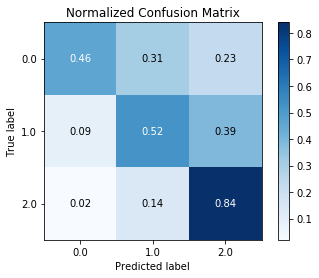

GaussianNB  accuracy: 0.5210989751238994


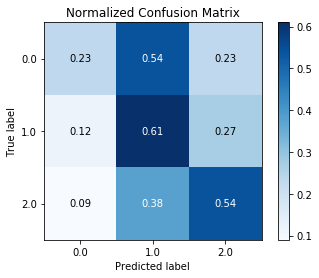

KNeighborsClassifier  accuracy: 0.5863927248231728


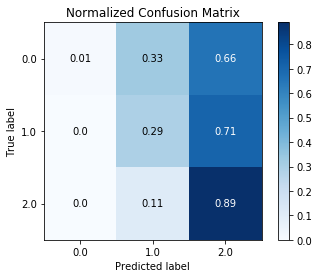

In [20]:
# training a DescisionTreeClassifier 
clf_dict = {}
clf_dict['DecisionTreeClassifier'] = DecisionTreeClassifier(max_depth = 3)
clf_dict['GaussianNB'] = GaussianNB()
clf_dict['KNeighborsClassifier'] = KNeighborsClassifier(n_neighbors = 30) 

train_classifier(clf_dict)

#### Inference

DecisionTreeClassifier works best on our dataset with the amount of missing data and with the current settings. 
0.69 accuracy score is not good but a better score could be achieved with some more tuning and experimentation.
Due to lack of computational power, unfortunately I have to stop here.